In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras.datasets import cifar10

from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib import ticker
plt.rcParams['figure.figsize'] = [16, 7]

# fix gpu memory management 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# enable reproducibility
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Important Note


In this notebook, you will see the words "signature" and "watermark" being used interchangeably. Although these words have different meanings, the API design sounded better with "signature" while the paper is better explained with the "watermark" concept, so you can assume they mean the same thing as long as this project is concerned.

# Loading and normalizing the dataset

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


# Visualizing some samples

In [3]:
def preview(size):
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    fig, ax = plt.subplots(size, size)
    for i in range(size):
        for j in range(size):
            idx = np.random.choice(len(x_train))
            ax[i, j].imshow(x_train[idx])
            ax[i, j].axis('off')
            ax[i, j].set(title=labels[y_train[idx, 0]])

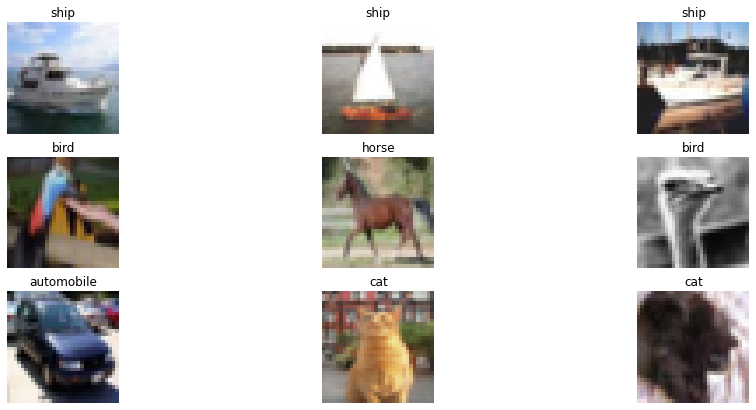

In [4]:
preview(3)

# Training a baseline model

In [5]:
from src.model import FreezeNet

MODEL_NAME = '100epochs_baseline'

train_parameters = {
    'steps_per_epoch' : None,
    'epochs' : 100,
    'validation_data' : (x_test,y_test),
    'batch_size' : 100
}

TRAINING = False
SAVING = False

if TRAINING:
    model = FreezeNet()
    model.fit(x_train, y_train, **train_parameters)
    
if SAVING:
    model.save_weights(f'models/{MODEL_NAME}/model')
    model.save_training_history(f'training_history/{MODEL_NAME}.csv')
    model.save_training_plot(f'img/{MODEL_NAME}.svg')

# How signatures work

* Generate a sequence of random weights using the hash of the data as a seed to the random number generator.
* Replace the weights of the model by the generated random weights.
* Check signature matching by comparing the weights of the model with the weights of the signature.

In [6]:
from src.signature import Signature

f = lambda x : "Verified" if x else "Not verified"

model = FreezeNet()

sig = Signature(b'Some block information', 4096)
other_sig = Signature(b'Some other block information', 4096)

sig.sign(model)

print(f"Checking model against original signature : {f(sig.verify(model))}")
print(f"Checking model against another signature : {f(other_sig.verify(model))}")

other_sig.sign(model)

print(f"Checking model against original signature : {f(sig.verify(model))}")
print(f"Checking model against another signature : {f(other_sig.verify(model))}")

Checking model against original signature : Verified
Checking model against another signature : Not verified
Checking model against original signature : Not verified
Checking model against another signature : Verified


# Evaluate the signature hit during training

The base result is that models can still learn while being watermarked. Furthermore, the size of the signature influences the speed of of learning. The longer the signature, the slower the training.

In [7]:
TRAINING = False
SAVING = False

if TRAINING:
    model_ratio = np.linspace(0.1, 1.0, 10)
    for ratio in model_ratio:
        model = FreezeNet()
        signature_length = int(model.n_weights() * ratio)
        sig = Signature(b'Some block information', signature_length)
        model.fit(x_train, y_train, **train_parameters, signature=sig)
        if SAVING:
            model.save_training_history(f'training_history/sig_{ratio:.1f}.csv')

# Evaluate the signature hit after training

## Accuracy of pretrained model after signing

To validate the proof of work, the goal is to prevent transfer learning as much as possible. Here, we visualize the accuracy of a pretrained model after signing it. We observe an exponential decay with the percentage of signed neurons.

In [8]:
def signature_hit(baseline):
    hit = {
        'signature_size' : [],
        'model_ratio' : [],
        'accuracy' : [],
        'f1' : [],
        'loss' : [],
    }
    
    model_ratio = np.linspace(0, 0.1, 50)

    for ratio in tqdm(model_ratio):
        model = FreezeNet()
        model.load_weights(baseline).expect_partial()
        
        sig_size = int(ratio*model.n_weights())
        signature = Signature(b'Some block information', sig_size)
        signature.sign(model)
        assert signature.verify(model)
        loss, acc, f1 = model.evaluate(x_test, y_test, verbose=0)
        
        hit['model_ratio'].append(ratio)  
        hit['signature_size'].append(sig_size)
        hit['accuracy'].append(acc)
        hit['f1'].append(f1)
        hit['loss'].append(loss)
        
    return hit

In [9]:
from scipy.optimize import least_squares

def exp(params, t, b=0):
    return  params[0] + params[1] * np.exp(np.array(t) * params[2]) - b

def exp_fit(x, y):
    x0 = np.array([1.0, 1.0, 0.0]) # initialization vector
    return least_squares(exp, x0, loss='soft_l1', args=(x, y)).x

def fit_hit(data):
    sol = exp_fit(data["model_ratio"], data["accuracy"])
    fig, ax = plt.subplots()
    ax.scatter(metrics["model_ratio"], metrics["accuracy"], label='Accuracy on test set')
    ax.plot(metrics["model_ratio"], exp(sol, metrics["model_ratio"]), label=f'{sol[0]:.1} + {sol[1]:.1} $e^{{{sol[2]:.0f}r}}$')
    ax.set(xlabel='Percentage of model weights watermarked', ylabel='Validation Accuracy', title="Pretrained model accuracy after applying watermark")
    ax.set_xticklabels([f'{_:.0%}' for _ in ax.get_xticks()])
    ax.set_yticklabels([f'{_:.0%}' for _ in ax.get_yticks()])
    ax.legend(loc="upper right")
    return fig

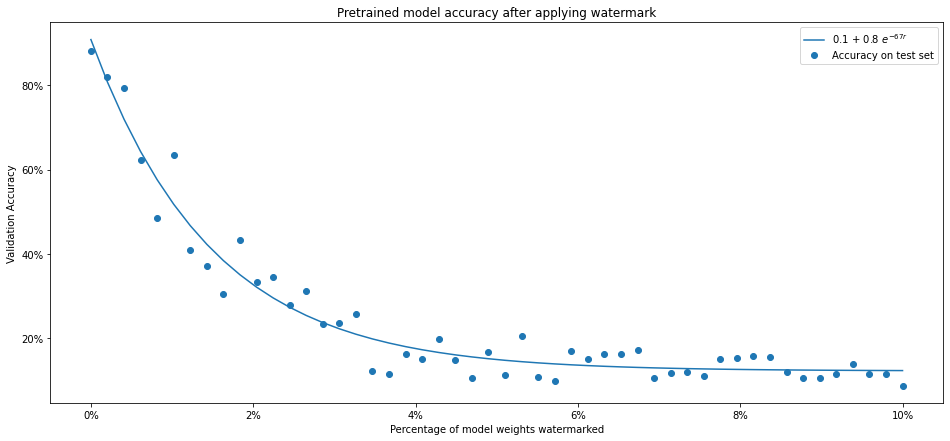

In [10]:
SAVING = False
BENCHMARK = False

if BENCHMARK:
    metrics = signature_hit(f'models/{MODEL_NAME}/model')
    pd.DataFrame(metrics).to_csv(f'signature_hit/{MODEL_NAME}_pretrained.csv')
    fig = fit_hit(metrics)
    fig.savefig(f'signature_hit/pretrained.svg')
else:
    metrics = pd.read_csv(f'signature_hit/{MODEL_NAME}_pretrained.csv')
    fig = fit_hit(metrics)
    if SAVING:
        fig.savefig(f'signature_hit/pretrained.svg')

## # of epochs to original accuracy

A typical transfer learning attack scenario would be to sign a pretrained model and retrain it to achieve its original accuracy. In order for the signature to be useful, it should be as efficient for the attacker to train the model from scratch as it is using this attack.

In [11]:
baseline = f'models/{MODEL_NAME}/model'
TRAINING = False
SAVING = False

if TRAINING:
    model_ratio = np.linspace(0.1, 1.0, 10)
    for ratio in model_ratio: # PARTIAL
        model = FreezeNet()
        model.load_weights(baseline).expect_partial()
        signature_length = int(model.n_weights() * ratio)
        sig = Signature(b'Some block information', signature_length)
        model.fit(x_train, y_train, **train_parameters, signature=sig)
        if SAVING:
            model.save_training_history(f'training_history/sig_{ratio:.1f}_pretrained.csv')

# Plotting results

In [12]:
def plot_results(scatter=False, regression=False, line=False, suffix='', only_acc=False):
    if not scatter and not regression and not line:
        raise ValueError("Set [scatter|regression|line] to True")
    
    colormap = cm.inferno
    model_ratio = np.linspace(0.0, 1.0, 11)
    
    if only_acc:
        fig, ax = plt.subplots(1, 1)
        
        for ratio in model_ratio:
            data = pd.read_csv(f'training_history/sig_{ratio:.1f}{suffix}.csv')
            data.index += 1
            color = np.array(colormap(ratio))

            if regression:
                line_fit = exp_fit(data.index, data['val_accuracy'])
                ax.plot(data.index, exp(data.index, *line_fit), label=f'{ratio:.1f}', c=color)

            if scatter:
                ax.scatter(data.index, data['val_accuracy'], c=color.reshape(1, -1))

            if line:
                ax.plot(data.index, data['val_accuracy'], label=f'{ratio:.0%}', c=color)

            ax.set(xlabel='Epochs', ylabel='Validation Accuracy', title='Learning accuracy for different watermark proportions')
            ax.set_yticklabels([f'{_:.0%}' for _ in ax.get_yticks()])
            ax.legend()
    else:
        fig, ax = plt.subplots(1, 2)
        
        for ratio in model_ratio:
            data = pd.read_csv(f'training_history/sig_{ratio:.1f}{suffix}.csv')
            data.index += 1
            color = np.array(colormap(ratio))

            if regression:
                line_fit = exp_fit(data.index, data['val_accuracy'])
                ax[0].plot(data.index, exp(data.index, *line_fit), label=f'{ratio:.1f}', c=color)

            if scatter:
                ax[0].scatter(data.index, data['val_accuracy'], c=color.reshape(1, -1))

            if line:
                ax[0].plot(data.index, data['val_accuracy'], label=f'{ratio:.0%}', c=color)

            ax[0].set(xlabel='Epochs', ylabel='Validation Accuracy', title='Learning accuracy for different watermark proportions')
            ax[0].set_yticklabels([f'{_:.0%}' for _ in ax[0].get_yticks()])
            ax[0].legend()

            if regression:
                line_fit = exp_fit(data.index, data['val_f1_score'])
                ax[1].plot(data.index, exp(data.index, *line_fit), label=f'{ratio:.1f}', c=colormap(ratio))

            if scatter:
                ax[1].scatter(data.index, data['val_f1_score'], c=color.reshape(1, -1))

            if line:
                ax[1].plot(data.index, data['val_f1_score'], label=f'{ratio:.0%}', c=colormap(ratio))

            ax[1].set(xlabel='Epochs', ylabel='Validation F1 score', title='F1 score as % of model frozen')
            ax[1].legend()
    
    return ax, fig

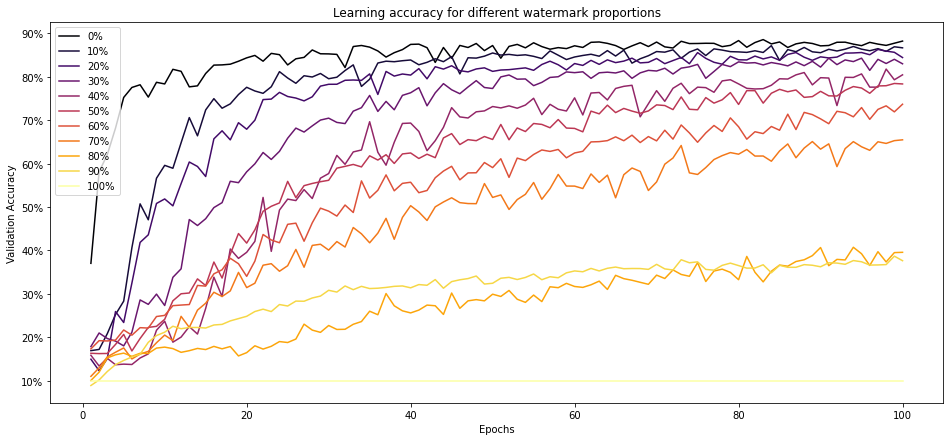

In [13]:
_, fig = plot_results(line=True, only_acc=True)

SAVING = False
if SAVING:
    fig.savefig('signature_hit/during_training.svg')

In [14]:
def plot_compare():
    fig, ax = plt.subplots(2, 2)
    index = 0
    
    for sig_ratio in np.arange(0.4, 0.8, 0.1):
        
        scratch = pd.read_csv(f'training_history/sig_{sig_ratio:.1f}.csv')
        pretrained = pd.read_csv(f'training_history/sig_{sig_ratio:.1f}_pretrained.csv')
        scratch.index += 1
        pretrained.index += 1
        row = index // 2
        col = index % 2

        ax[row][col].plot(scratch.index, scratch['val_accuracy'], label=f'Honest training', c='blue')
        ax[row][col].plot(pretrained.index, pretrained['val_accuracy'], label=f'Transfer attack', c='red')
        ax[row][col].set(xlabel='Epochs', ylabel='Validation accuracy', title=f'Training with {sig_ratio:.0%} of weights watermarked')
        ax[row][col].set_yticklabels([f'{_:.0%}' for _ in ax[row][col].get_yticks()])
        ax[row][col].legend()
        
        index += 1
    plt.tight_layout()
    return ax, fig

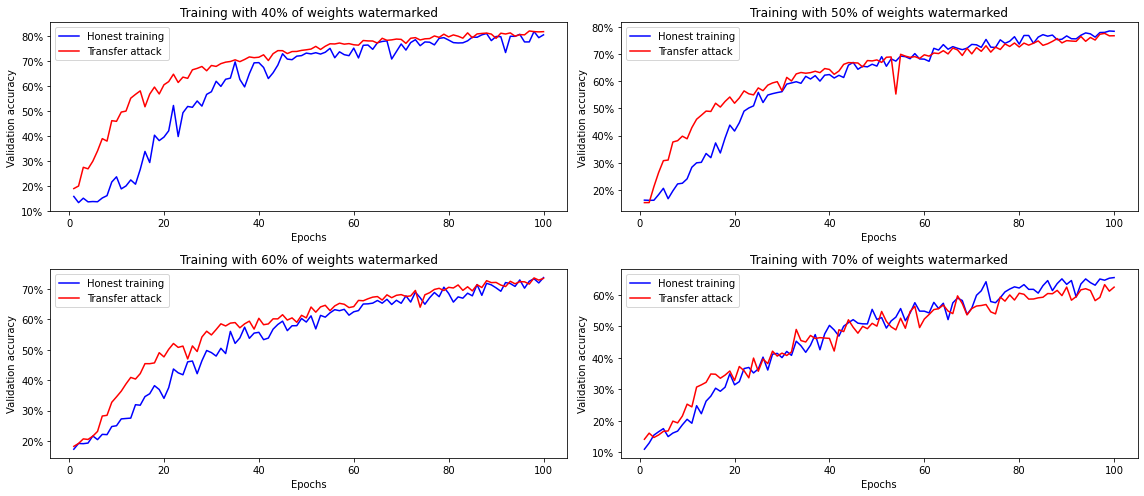

In [15]:
_, fig = plot_compare()

SAVING = False
if SAVING:
    fig.savefig(f'signature_hit/transfer_attack_comparison.svg')